## 3D-VAR Inner Domain Wind Retrieval Testing

In [ ]:
%matplotlib inline

In [ ]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MultipleLocator, ScalarFormatter

from pyart.io import read_grid, write_grid
from pyart.graph import cm

from winds.core import Profile, Solver, Metric
from winds.var import retrieve, common

### Helper functions

In [ ]:
def _plot_cappi(
        grid, field, height=0, scale=1.0, cmap=None, norm=None, ticks=None, fig=None, ax=None):
    """
    """
    
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    
    # Parse grid coordinates
    x = grid.x['data'] / 1000.0
    y = grid.y['data'] / 1000.0
    z = grid.z['data'] / 1000.0
    
    # Parse grid data
    data = scale * grid.fields[field]['data'][height]
    
    # Create quadmesh
    qm = ax.pcolormesh(
        x, y, data, cmap=cmap, norm=norm, alpha=None, shading='flat', rasterized=True)
    
    # Create colour bar
    fig.colorbar(mappable=qm, ax=ax, orientation='vertical', ticks=ticks)
    
    # Set title
    if 'radar_0_instrument_name' in grid.metadata:
        title = '{} {:.1f} km\n{}'.format(
            grid.metadata['radar_0_instrument_name'], z[height], field)
    else:
        title = 'N/A {:.1f} km\n{}'.format(z[height], field)
    ax.set_title(title)
    
    return

#### Format color maps

In [ ]:
# Define color maps
cmap_refl = cm.NWSRef
cmap_vdop = cm.NWSVel
cmap_gqi = cm.Carbone17
cmap_dist = cm.BlueBrown10
cmap_weight = cm.Carbone17
cmap_uvel = cm.NWSVel
cmap_vvel = cm.NWSVel
cmap_wvel = cm.BuDRd18
cmap_hdiv = cm.BuDRd18
cmap_fall = cm.Carbone42
cmap_cover = cm.LangRainbow12

# Normalize colour maps
norm_refl = BoundaryNorm(np.arange(-10, 65, 5), cmap_refl.N)
norm_vdop = BoundaryNorm(np.arange(-30, 32, 2), cmap_vdop.N)
norm_gqi = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_gqi.N)
norm_dist = BoundaryNorm(np.arange(0, 2.1, 0.1), cmap_dist.N)
norm_weight = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_weight.N)
norm_uvel = BoundaryNorm(np.arange(-30, 32, 2), cmap_uvel.N)
norm_vvel = BoundaryNorm(np.arange(-30, 32, 2), cmap_vvel.N)
norm_wvel = BoundaryNorm(np.arange(-8, 8.5, 0.5), cmap_wvel.N)
norm_hdiv = BoundaryNorm(np.arange(-8, 8.5, 0.5), cmap_hdiv.N)
norm_cover = BoundaryNorm(np.arange(0, 5, 1), cmap_cover.N)
norm_fall = BoundaryNorm(np.arange(0, 8.1, 0.1), cmap_fall.N)

# Define colour bar ticks
ticks_refl = np.arange(-10, 70, 10)
ticks_vdop = np.arange(-30, 40, 10)
ticks_gqi = np.arange(0, 1.2, 0.2)
ticks_dist = np.arange(0, 2.4, 0.4)
ticks_weight = np.arange(0, 1.2, 0.2)
ticks_uvel = np.arange(-30, 40, 10)
ticks_vvel = np.arange(-30, 40, 10)
ticks_wvel = np.arange(-8, 10, 2)
ticks_hdiv = np.arange(-8, 10, 2)
ticks_fall = np.arange(0, 9, 1)
ticks_cover = np.arange(0, 5, 1)

#### Define grids

In [19]:
# Read grids
csapr = read_grid('/storage/kirk/outgoing/mariko/sgpcsaprinnerC1mmcgI7.b1.20110520.110800.cdf')
kvnx = read_grid('/storage/kirk/outgoing/mariko/nexradwsr88dV06innerC1mmcgKVNX.b1.20110520.110651.cdf')
kict = read_grid('/storage/kirk/outgoing/mariko/nexradwsr88dV03innerC1mmcgKICT.b1.20110520.110907.cdf')

# List of grids
grids = [csapr, kvnx, kict]

#### Define solver

In [20]:
solver = Solver(
    grids, constant_resolution=True, method='CG', maxiter=600, gtol=0.1, 
    continuity='Potvin', smoothness='Potvin', impermeability='weak', 
    lambda_o=1.0, lambda_c=500.0, lambda_s1=0.1, lambda_s2=0.1, lambda_s3=0.1, 
    lambda_s4=0.01, lambda_ub=0.01, lambda_vb=0.01, lambda_wb=0.0, 
    lambda_p=1000.0, length_scale=500.0, first_pass=True, maxiter_first_pass=50, 
    finite_order='low', proc=1, debug=False, verbose=True)

x-dimension resolution: 500.00 m
y-dimension resolution: 500.00 m
z-dimension resolution: 500.00 m
Functional size: 3178413
Solver target time: 2011-05-20 11:08:00


#### Grid quality index and nearest neighour weight

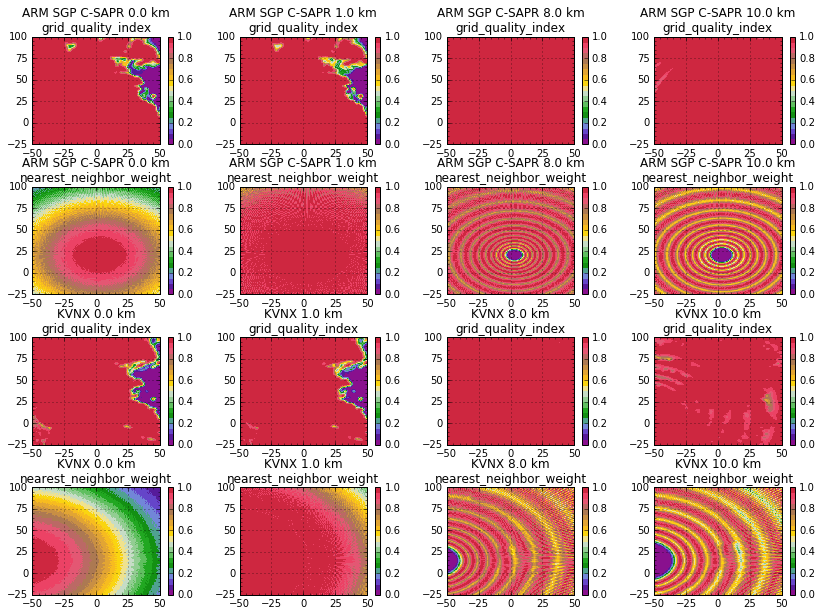

In [21]:
subs = {'xlim': (-50, 50), 'ylim': (-25, 100)}
figs = {'figsize': (14, 10)}
fig, axes = plt.subplots(nrows=4, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

heights = [0, 2, 16, 20]

for i, height in enumerate(heights):
    
    # (a) CSAPR grid quality index
    _plot_cappi(csapr, 'grid_quality_index', height=height, cmap=cmap_gqi,
                norm=norm_gqi, ticks=ticks_gqi, fig=fig, ax=axes[0,i])
    
    # (b) CSAPR nearest neighbor weight
    _plot_cappi(csapr, 'nearest_neighbor_weight', height=height, cmap=cmap_weight, 
                norm=norm_weight, ticks=ticks_weight, fig=fig, ax=axes[1,i])
    
    # (a) KVNX grid quality index
    _plot_cappi(kvnx, 'grid_quality_index', height=height, cmap=cmap_gqi,
                norm=norm_gqi, ticks=ticks_gqi, fig=fig, ax=axes[2,i])
    
    # (b) KVNX nearest neighbor weight
    _plot_cappi(kvnx, 'nearest_neighbor_weight', height=height, cmap=cmap_weight, 
                norm=norm_weight, ticks=ticks_weight, fig=fig, ax=axes[3,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(25))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

#### Compute reflectivity of radar network

In [22]:
ignore_radars = [
    'ARM SGP C-SAPR',
    ]

common.add_grid_network_reflectivity(
    grids, solver, ignore_radars=ignore_radars, use_weights=True, 
    debug=True, verbose=True)

Reflectivity observations from grid: KVNX
Min reflectivity weight: 0.000
Max reflectivity weight: 1.000
Reflectivity observations from grid: KICT
Min reflectivity weight: 0.001
Max reflectivity weight: 1.000
Min network reflectivity: -3.459 dBZ
Max network reflectivity: 54.304 dBZ


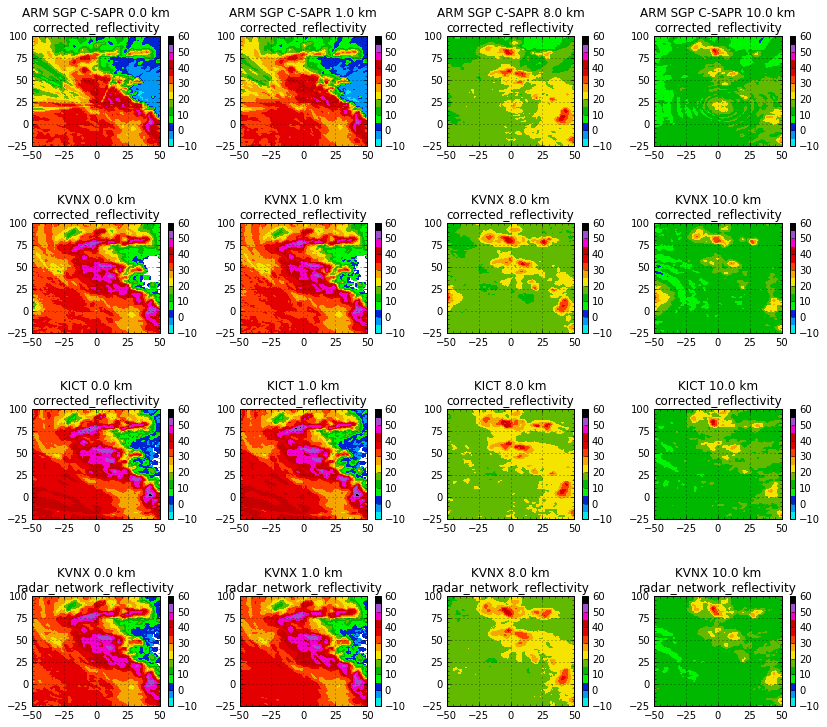

In [23]:
subs = {'xlim': (-50, 50), 'ylim': (-25, 100)}
figs = {'figsize': (14, 12)}
fig, axes = plt.subplots(nrows=4, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.3, hspace=0.7)

heights = [0, 2, 16, 20]

for i, height in enumerate(heights):
    
    # (a) CSAPR-I7 reflectivity
    _plot_cappi(csapr, 'corrected_reflectivity', height=height, cmap=cmap_refl,
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) KVNX reflectivity
    _plot_cappi(kvnx, 'corrected_reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[1,i])
    
    # (c) KICT reflectivity
    _plot_cappi(kict, 'corrected_reflectivity', height=height, cmap=cmap_refl,
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[2,i])
    
    # (d) Network reflectivity
    _plot_cappi(kvnx, 'radar_network_reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[3,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(25))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

#### Atmospheric profile data

In [24]:
# Define sounding data
filename = '/storage/kirk/outgoing/mariko/sgpmergesonde1maceC1.c1.20110520.000000.cdf'
sonde = netCDF4.Dataset(filename, mode='r')

# Create profile
profile = common.arm_mergesonde_profile(
    solver, sonde, rate_method='cubic', debug=True, verbose=True)

Solver target time: 2011-05-20 11:08:00
Sounding target time: 2011-05-20 11:08:00


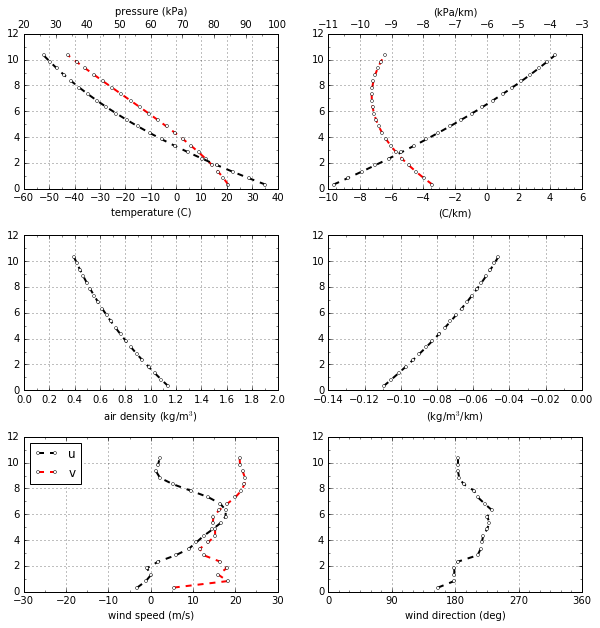

In [25]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(wspace=0.2, hspace=0.3)

# (a-b) Temperature and pressure with height
axa = fig.add_subplot(321, xlim=(-60, 40), ylim=(0, 12))
axa.plot(profile.tdry, profile.alt / 1000.0, 'r--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k')
axa.xaxis.set_major_locator(MultipleLocator(10))
axa.xaxis.set_minor_locator(MultipleLocator(5))
axa.yaxis.set_major_locator(MultipleLocator(2))
axa.yaxis.set_minor_locator(MultipleLocator(1))
axa.set_xlabel('temperature (C)')
axa.grid(which='major')
axb = axa.twiny()
axb.plot(profile.pres, profile.alt / 1000.0, 'k--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k')
axb.xaxis.set_major_locator(MultipleLocator(10))
axb.xaxis.set_minor_locator(MultipleLocator(5))
axb.set_xlabel('pressure (kPa)')

# (c-d) Temperature and pressure rates of change
axc = fig.add_subplot(322, xlim=(-10, 6), ylim=(0, 12))
axc.plot(profile.dtdrydz * 1000.0, profile.alt / 1000.0, 'r--', lw=2, 
         marker='o', ms=3, mfc='w', mec='k')
axc.xaxis.set_major_locator(MultipleLocator(2))
axc.xaxis.set_minor_locator(MultipleLocator(0.5))
axc.yaxis.set_major_locator(MultipleLocator(2))
axc.yaxis.set_minor_locator(MultipleLocator(1))
axc.set_xlabel('(C/km)')
axc.grid(which='major')
axd = axc.twiny()
axd.plot(profile.dpresdz * 1000.0, profile.alt / 1000.0, 'k--', lw=2, 
         marker='o', ms=3, mfc='w', mec='k')
axd.xaxis.set_major_locator(MultipleLocator(1))
axd.xaxis.set_minor_locator(MultipleLocator(0.5))
axd.set_xlabel('(kPa/km)')

# (e) Air density
axe = fig.add_subplot(323, xlim=(0, 2), ylim=(0, 12))
axe.plot(profile.rho, profile.alt / 1000.0, 'k--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k')
axe.xaxis.set_major_locator(MultipleLocator(0.2))
axe.xaxis.set_minor_locator(MultipleLocator(0.1))
axe.yaxis.set_major_locator(MultipleLocator(2))
axe.yaxis.set_minor_locator(MultipleLocator(1))
axe.set_xlabel('air density (kg/m$^3$)')
axe.grid(which='major')

# (f) Air density rate of change
axf = fig.add_subplot(324, xlim=(-0.14, 0), ylim=(0, 12))
axf.plot(profile.drhodz * 1000.0, profile.alt / 1000.0, 'k--', lw=2, 
         marker='o', ms=3, mfc='w', mec='k')
axf.xaxis.set_major_locator(MultipleLocator(0.02))
axf.xaxis.set_minor_locator(MultipleLocator(0.01))
axf.yaxis.set_major_locator(MultipleLocator(2))
axf.yaxis.set_minor_locator(MultipleLocator(1))
axf.set_xlabel('(kg/m$^3$/km)')
axf.grid(which='major')

# (g) Wind speed
axg = fig.add_subplot(325, xlim=(-30, 30), ylim=(0, 12))
axg.plot(profile.u, profile.alt / 1000.0, 'k--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k', label='u')
axg.plot(profile.v, profile.alt / 1000.0, 'r--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k', label='v')
axg.xaxis.set_major_locator(MultipleLocator(10))
axg.xaxis.set_minor_locator(MultipleLocator(5))
axg.yaxis.set_major_locator(MultipleLocator(2))
axg.yaxis.set_minor_locator(MultipleLocator(1))
axg.set_xlabel('wind speed (m/s)')
axg.grid(which='major')
axg.legend(loc='upper left')

# (h) Wind direction
axh = fig.add_subplot(326, xlim=(0, 360), ylim=(0, 12))
axh.plot(profile.wdir, profile.alt / 1000.0, 'k--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k')
axh.xaxis.set_major_locator(MultipleLocator(90))
axh.xaxis.set_minor_locator(MultipleLocator(15))
axh.yaxis.set_major_locator(MultipleLocator(2))
axh.yaxis.set_minor_locator(MultipleLocator(1))
axh.set_xlabel('wind direction (deg)')
axh.grid(which='major')

#### Hydrometeor fall speed

In [27]:
common.add_fall_speed_caya(grids, solver, profile=profile, debug=True, verbose=True)

Min hydrometeor fall speed: 0.000 m/s
Max hydrometeor fall speed: 8.374 m/s


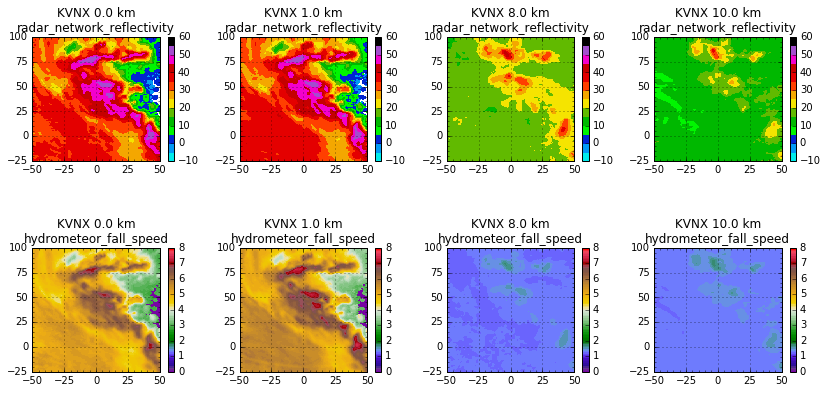

In [28]:
subs = {'xlim': (-50, 50), 'ylim': (-25, 100)}
figs = {'figsize': (14, 6)}
fig, axes = plt.subplots(nrows=2, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.3, hspace=0.7)

heights = [0, 2, 16, 20]

for i, height in enumerate(heights):
    
    # (a) Network reflectivity
    _plot_cappi(kvnx, 'radar_network_reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Hydrometeor fall speed
    _plot_cappi(kvnx, 'hydrometeor_fall_speed', height=height, cmap=cmap_fall, 
                norm=norm_fall, ticks=ticks_fall, fig=fig, ax=axes[1,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(25))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

#### Radar velocity observation weights

In [29]:
common.add_grid_radial_velocity_weight(
    grids, solver, use_weights=True, debug=True, verbose=True)

Radial velocities from grid: ARM SGP C-SAPR
Min radial velocity weight: 0.000
Max radial velocity weight: 1.000
Radial velocities from grid: KVNX
Min radial velocity weight: 0.000
Max radial velocity weight: 1.000
Radial velocities from grid: KICT
Min radial velocity weight: 0.000
Max radial velocity weight: 1.000


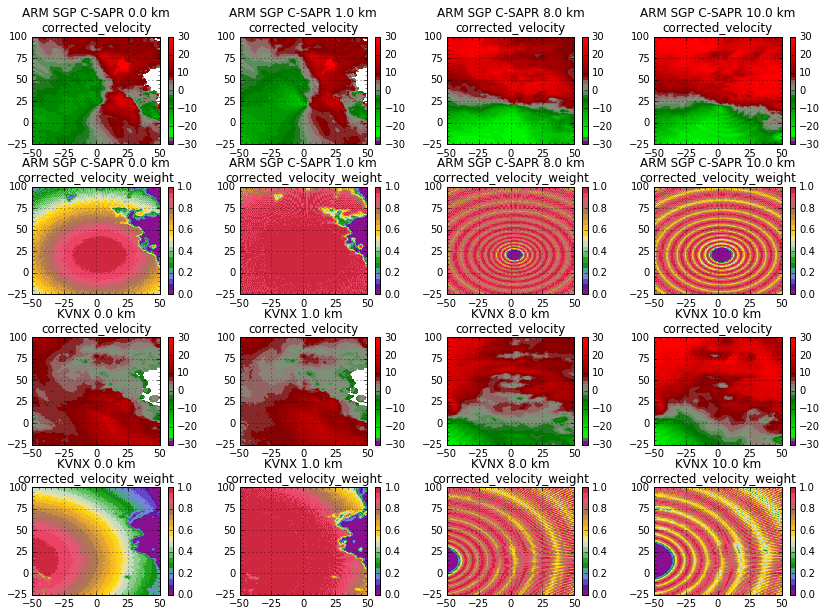

In [30]:
subs = {'xlim': (-50, 50), 'ylim': (-25, 100)}
figs = {'figsize': (14, 10)}
fig, axes = plt.subplots(nrows=4, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

heights = [0, 2, 16, 20]

for i, height in enumerate(heights):
    
    # (a) CSAPR radial velocity
    _plot_cappi(csapr, 'corrected_velocity', height=height, cmap=cmap_vdop,
                norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[0,i])
    
    # (b) CSAPR radial velocity weight
    _plot_cappi(csapr, 'corrected_velocity_weight', height=height, cmap=cmap_weight, 
                norm=norm_weight, ticks=ticks_weight, fig=fig, ax=axes[1,i])
    
    # (a) KVNX radial velocity
    _plot_cappi(kvnx, 'corrected_velocity', height=height, cmap=cmap_vdop,
                norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[2,i])
    
    # (b) KVNX radial velocity weight
    _plot_cappi(kvnx, 'corrected_velocity_weight', height=height, cmap=cmap_weight, 
                norm=norm_weight, ticks=ticks_weight, fig=fig, ax=axes[3,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(25))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

#### Radar coverage

In [31]:
common.add_grid_coverage(grids, solver, atol=0.1, debug=True, verbose=True)

Coverage by grid: ARM SGP C-SAPR
Coverage by grid: KVNX
Coverage by grid: KICT
Min radar coverage: 0
Max radar coverage: 3


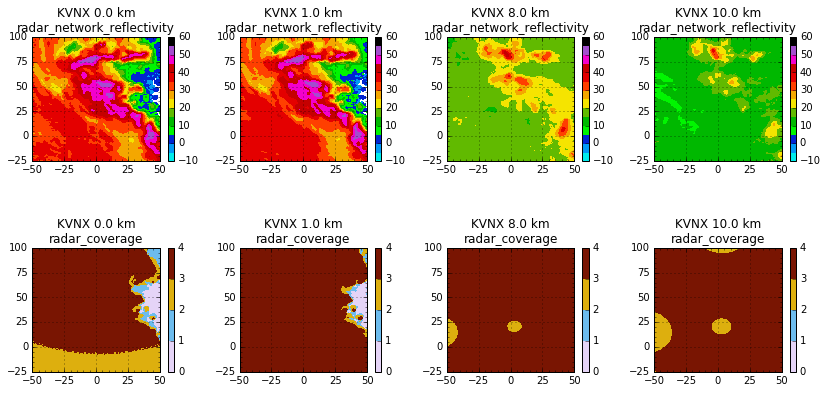

In [32]:
subs = {'xlim': (-50, 50), 'ylim': (-25, 100)}
figs = {'figsize': (14, 6)}
fig, axes = plt.subplots(nrows=2, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.3, hspace=0.7)

heights = [0, 2, 16, 20]

for i, height in enumerate(heights):
    
    # (a) Network reflectivity
    _plot_cappi(kvnx, 'radar_network_reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Radar coverage
    _plot_cappi(kvnx, 'radar_coverage', height=height, cmap=cmap_cover, 
                norm=norm_cover, ticks=ticks_cover, fig=fig, ax=axes[1,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(25))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

#### Multi-Doppler wind retrieval

In [ ]:
conv = retrieve.solve_wind_field(
    grids, solver=solver, profile=profile, background='profile', first_guess='zero',
    fall_speed='Caya', legacy=True, debug=True, verbose=True)

#### Check wind retrieval results

In [ ]:
metric = Metric(conv, grids, solver, profile, debug=True, verbose=True)

#### Plot metrics as a function of height

In [ ]:
fig = plt.figure(figsize=(12, 8))

# (a) Relative mass continuity residual
axa = fig.add_subplot(221, xlim=(0, 25), ylim=(0, 5))
axa.plot(metric.alpha_profile * 100.0, metric.solver.z / 1000.0, 'k--', lw=2, 
         marker='o', ms=4, mec='k', mfc='w', alpha=None, label='$\alpha$')
axa.xaxis.set_major_locator(MultipleLocator(5))
axa.xaxis.set_minor_locator(MultipleLocator(1))
axa.yaxis.set_major_locator(MultipleLocator(1))
axa.yaxis.set_minor_locator(MultipleLocator(0.5))
axa.set_xlabel('continuity residual (%)')
axa.set_ylabel('height (km AGL)')
axa.grid(which='major')

# (b) Radar observation residual
axb = fig.add_subplot(222, xlim=(0, 4), ylim=(0, 5))
axb.plot(metric.ARM_SGP_CSAPR['vdop_rmse_profile'], metric.solver.z / 1000.0, 'k--', 
         lw=2, marker='s', ms=5, mec='k', mfc='w', alpha=None, label='CSAPR')
axb.plot(metric.KVNX['vdop_rmse_profile'], metric.solver.z / 1000.0, 'k--', 
         lw=2, marker='>', ms=5, mec='k', mfc='k', alpha=None, label='KVNX')
axb.plot(metric.KICT['vdop_rmse_profile'], metric.solver.z / 1000.0, 'k--', 
         lw=2, marker='D', ms=5, mec='k', mfc='k', alpha=None, label='KICT')
axb.xaxis.set_major_locator(MultipleLocator(0.5))
axb.xaxis.set_minor_locator(MultipleLocator(0.1))
axb.yaxis.set_major_locator(MultipleLocator(1))
axb.yaxis.set_minor_locator(MultipleLocator(0.5))
axb.set_xlabel('velocity residual (m/s)')
axb.set_ylabel('height (km AGL)')
axb.legend(loc='upper right')
axb.grid(which='major')

# (c) Cost function value
axc = fig.add_subplot(223, xlim=(0, 1000), ylim=(1.0e5, 1.0e8))
axc.semilogy(metric.cost_iter, metric.cost_value, 'k-', lw=1)
axc.xaxis.set_major_locator(MultipleLocator(250))
axc.xaxis.set_minor_locator(MultipleLocator(50))
axc.set_xlabel('iteration')
axc.set_ylabel('cost function value')
axc.grid(which='major')

# (d) Cost function gradient magnitude
axd = fig.add_subplot(224, xlim=(0, 1000), ylim=(1.0e1, 1.0e5))
axd.semilogy(metric.cost_grad_iter, metric.cost_grad_mag, 'k-', lw=1)
axd.xaxis.set_major_locator(MultipleLocator(250))
axd.xaxis.set_minor_locator(MultipleLocator(50))
axd.set_xlabel('iteration')
axd.set_ylabel('gradient norm')
axd.grid(which='major')

#### Plot wind retrieval results

In [ ]:
subs = {'xlim': (-50, 50), 'ylim': (-25, 100)}
figs = {'figsize': (16, 18)}
fig, axes = plt.subplots(nrows=6, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.4, hspace=0.5)

heights = [0, 3, 16, 20]

for i, height in enumerate(heights):
    
    # (a) Network reflectivity
    _plot_cappi(conv, 'radar_network_reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Eastward wind component
    _plot_cappi(conv, 'eastward_wind_component', height=height, cmap=cmap_uvel, 
                norm=norm_uvel, ticks=ticks_uvel, fig=fig, ax=axes[1,i])
    
    # (c) Northward wind component
    _plot_cappi(conv, 'northward_wind_component', height=height, cmap=cmap_vvel, 
                norm=norm_vvel, ticks=ticks_vvel, fig=fig, ax=axes[2,i])
    
    # (d) Vertical wind component
    _plot_cappi(conv, 'vertical_wind_component', height=height, cmap=cmap_wvel, 
                norm=norm_wvel, ticks=ticks_wvel, fig=fig, ax=axes[3,i])
    
    # (e) Horizontal wind divergence
    _plot_cappi(conv, 'horizontal_wind_divergence', height=height, scale=1.0e3, 
                cmap=cmap_hdiv, norm=norm_hdiv, ticks=ticks_hdiv, fig=fig, 
                ax=axes[4,i])
    
    # (f) Radar coverage
    _plot_cappi(conv, 'radar_coverage', height=height, cmap=cmap_cover, 
                norm=norm_cover, ticks=ticks_cover, fig=fig, ax=axes[5,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(25))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')